# Policy Gradient
对应《强化学习的数学原理》第9章
<br>代码对应《动手学强化学习》第9章 [请点击这里](https://hrl.boyuai.com/chapter/2/%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E7%AE%97%E6%B3%95)

## 创建环境

In [4]:
import gymnasium as gym
print(gym.__version__)   #1.1.1
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

1.1.1


In [5]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

## 创建策略网络

In [6]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

'CartPole-v1'的动作只有2个，左和右，策略网络输出的是每个动作的概率

## reinforce算法

### reinforce算法的推导

<img src="./picture9_1.png" alt="插入图片哈哈" width="100%">

### 代码实现

In [7]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):  # 把state传入动作网络，得到选择每个动作的概率，就按这个概率选择动作，输出动作的编号，是标量
        state = torch.from_numpy(state.reshape(1, -1)).float().to(self.device)
        probs = self.policy_net(state)                        # 几个动作，这里输出几个概率，概率和为1
        action_dist = torch.distributions.Categorical(probs)  # 构成一个分布
        action = action_dist.sample()                         # 按照概率选动作
        return action.item()                                  # 返回一个标量，动作的编号

    def update(self, transition_dict):             # 传进来的是一个episode的
        reward_list = transition_dict['rewards']   # 是个一维list
        state_list = transition_dict['states']     # 是个二维np.array
        action_list = transition_dict['actions']   # 一维list，是动作的索引

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起,反向算
            reward = reward_list[i]
            state = torch.tensor(state_list[i].reshape(1, -1)).float().to(self.device) #state_list是二维的list，state_list[i]是一维list,torch.tensor都得二维的

            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)        #action_list是一维list,是动作索引，action_list[i]就是一个标量，

            log_probability = torch.log(self.policy_net(state).gather(1, action))      #policy_net(state)输出2个概率，选择它实际选择动作的概率

            G = self.gamma * G + reward
            loss = -log_probability * G    # loss = -log_prob * (self.gamma * G + reward)

            loss.backward()
        self.optimizer.step()

1，走完了一个episode,然后开始倒着取，最后一个奖励，状态，动作，然后把这个状态传入网络，并得到两个概率，然后选择刚刚的那个动作的概率，然后torch.log，
<br>G = self.gamma * G + reward loss = -log_prob * G ，然后loss.backward,反向传播，
<br>直到把这个episode反着走完，反向传播的梯度会累计，loss.backward()，loss.backward()，梯度会累计，
<br>走完了这个episode才更新网络，self.optimizer.step() 。
<br>走完一个episode才更新，更新完走下一个episode。
<br>2，G在这里视为常数，G大，就说明这个动作收益大。loss = -log_prob * G要让loss小，如果G大，那么-log_prob就小，那么这个动作的概率就大。

## 训练

In [8]:
learning_rate = 1e-3
num_episodes = 500
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,device)

### 训练函数

In [9]:
def train_function(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state,info = env.reset(seed=0)  #state是一维的np.array
                done = False
                while not done:
                    action = agent.take_action(state)  #一个标量
                    next_state, reward, terminated, truncated, info = env.step(action)
                    # next_state是1维np.array，reward是个标量
                    done = terminated or truncated

                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

### 开始训练

In [10]:
return_list = train_function(env, agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/50 [00:00<?, ?it/s]

### 训练完成

In [15]:
torch.save(agent.policy_net.state_dict(), "reinforce_cartpole.pth")

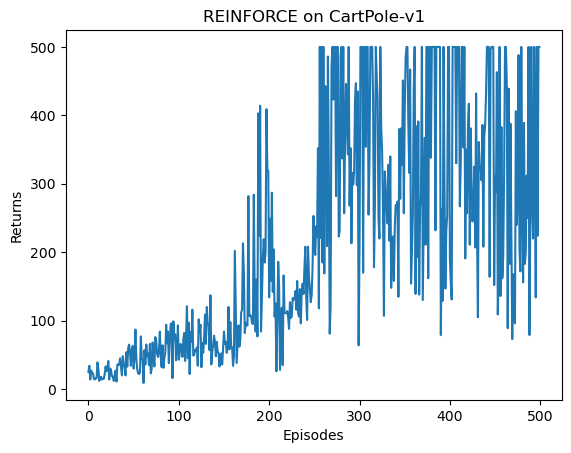

In [12]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

In [13]:
def moving_average(a, window_size):   # 滑动平均
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

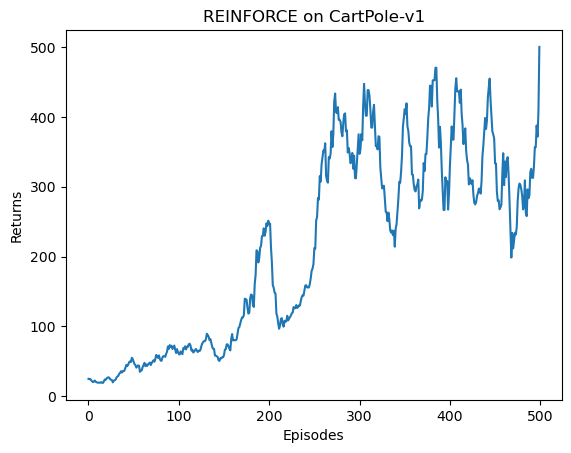

In [14]:
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

reinforce算法文字描述：
<br>初始化一个神经网络，输入维度为状态数，输出维度为动作个数，然后加一个softmax分类，输出的是各个动作的概率。
<br>然后根据蒙特卡洛采样，开始走第一个episode,直到结束，记录下这个episode的每个状态，动作，奖励。
<br>然后反向走，最后一个奖励，状态，动作，然后把这个状态传入网络，并得到两个概率，然后选择刚刚的那个动作的概率进行torch.log，
<br>然后G = self.gamma * G + reward， loss = -log_prob * G ，然后loss.backward,反向传播，
<br>直到把这个episode反着走完，反向传播的梯度会累计，走完了这个episode才更新网络。
<br>然后开始走第二个episode......
<br>每一个episode更新一次网络。